In [3]:
#We are building the Char level RNN.
#Task - To predict the nationality for a given name

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import string
import numpy as np

In [3]:
# Read the data and separate the name and nationality
languages = []
data = []
X = []
y = []

with open("surnames/surnames.csv", 'r') as f:
    text = f.readlines()
    for line in text[1:]:  #starting from 1 to beacause at zero index we have column headers
        line = line.split(",")
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

n_languages = len(languages)

In [4]:
torch.manual_seed(42)
# Split the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = y)
print("Training Data: ", len(X_train))
print("Testing Data: ", len(X_test))

Training Data:  8784
Testing Data:  2196


In [5]:
#Build the Vocabulary
#get all the letters
all_letters = string.ascii_letters + ".,;"
vocab_size = len(all_letters)

print("Number of letters: ", vocab_size)

Number of letters:  55


In [6]:
# Define a function to convert the name into one-hot vector 
def name_vector(name):
    rep = torch.zeros(len(name), 1, vocab_size)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [7]:
# For all the 6 letter in "Hritik" it will create a vocab_size long tensor.
# for char index in vocab it will put 1 otherwise 0
# These are 6 separate char - of size (1,55) -- where 55 is our vocab_size
name_vector("Hritik").shape 

torch.Size([6, 1, 55])

In [8]:
# We also have to repersent the nationality in vectors 
# It will return the index for crossponding nationality in languages array
def nationality_vector(lang):
    return torch.tensor([languages.index(lang)], dtype = torch.long)

In [9]:
nationality_vector("Italian")

tensor([6])

In [10]:
# Create a function to load the dataset 
def dataloader(batch_size, X, y):
    to_ret = []
    for i in range(batch_size): # Here batch_size is the examples we one to proceed in one training iteration
        index = np.random.randint(len(X))
        name, lang = X[index], y[index]  #get the data at the random index
        to_ret.append((name, lang, name_vector(name), nationality_vector(lang)))

    return to_ret

In [11]:
# Build the RNN Model

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #input to hidden layer
        self.i2o = nn.Linear(input_size + hidden_size, output_size) #input to output layer
        self.softmax = nn.LogSoftmax(dim = 1) #softmax for classification 

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) #concatenate tensors on column wise
        hidden = self.i2h(combined) 
        output = self.i2o(combined) 
        output = self.softmax(output)
        return output, hidden
        
    def init_hidden(self): # Define the initail hidden state
        return torch.zeros(1, self.hidden_size)

In [12]:
#function to train the data

def train(model, optmizer, batch_size):
    
    total_loss = 0
    optimizer.zero_grad()
    
    # load the data 
    data = dataloader(batch_size, X_train, y_train)
    for name, language, name_tensor, nationality_tensor in data:
        hidden = model.init_hidden() # initilize the hidden start for 1st layer of RNN
        for i in range(name_tensor.size()[0]): # For all the character in name we want to run RNN sequentially
            output, hidden = model(name_tensor[i], hidden) 
            
    
        loss = F.cross_entropy(output, nationality_tensor)
        loss.backward()
        total_loss += loss
    optimizer.step()
    
    return total_loss/batch_size

In [20]:
# Hyperparamters
batch_size = 16
max_iter = 5000
n_hidden = 128
model = RNN(vocab_size, n_hidden, n_languages)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_list = []

for i in range(max_iter):
    loss = train(model, optimizer, batch_size)

    if i%1000 == 0 or i == max_iter-1:
        print(f'loss for {i}/{max_iter} : {loss:.4f}')
    loss_list.append(loss.log10().item())
    



loss for 0/5000 : 2.9241
loss for 1000/5000 : 1.3550
loss for 2000/5000 : 0.9844
loss for 3000/5000 : 1.1569
loss for 4000/5000 : 1.0527
loss for 4999/5000 : 0.6396


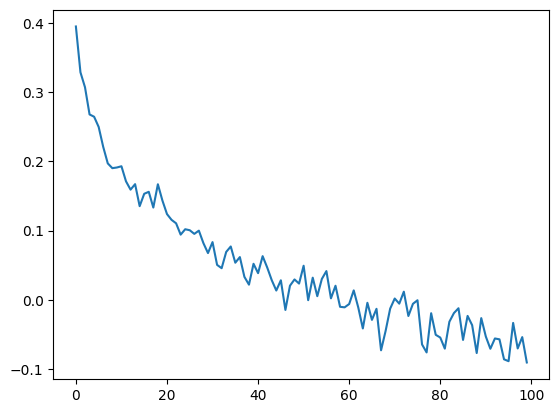

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(torch.tensor(loss_list).view(-1,50).mean(1))

In [22]:
# Evaluate the loss
@torch.no_grad()
def eval(split):

    x,y = {
        'train':(X_train,y_train),
        'test':(X_test,y_test)
    }[split]

    data = dataloader(batch_size, x, y)
    correct = 0

    for name, language, name_tensor, nationality_tensor in data:
        model.eval()
        hidden = model.init_hidden()
        for i in range(name_tensor.size()[0]):
            output, hidden = model(name_tensor[i], hidden)
        
        loss = F.cross_entropy(output, nationality_tensor)
    print(split, loss.item())

eval('train')
eval('test')

train 0.0317903570830822
test 0.017543261870741844


In [25]:
# Predictions
def inference(name):
    model.eval()
    name_tensor = name_vector(name)
    hidden = model.init_hidden()
    for i in range(name_tensor.size()[0]):
        output, hidden = model(name_tensor[i], hidden)
    return output

out = inference("Hritik")
index = torch.argmax(out)
print(languages[index])
 

Russian
